In [938]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pickle
import scipy.stats as stats
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from functools import partial
from scipy.stats import linregress
from imblearn.over_sampling import SMOTE

C:\Users\maaya\AppData\Local\Temp\ipykernel_2596\2258422319.py:6: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [931]:
df = pd.read_pickle("all_df.pkl")
test_df_original = pd.read_pickle("all_df_test.pkl")

In [932]:
data_dict = pd.read_pickle("data_dict.pickle")

In [948]:
def run_and_eval(model_class, X_train, y_train, X_test, y_test):
    model = model_class
    model.fit(X_train.drop("patient id", axis=1), y_train)
    y_pred = model.predict(X_test.drop("patient id", axis=1))
    X_test_copy = X_test.copy()
    X_test_copy['preds'] = y_pred
    y_pred_per_patient = pd.DataFrame(X_test_copy.groupby('patient id')['preds'].apply(lambda x: (x == 1).any()).astype(int))['preds']
    evaluate_model(y_true=y_test, y_pred=y_pred_per_patient)
    return y_pred

In [934]:
def evaluate_model(y_true,y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    print("Accuracy:", accuracy)
    precision = precision_score(y_true, y_pred)
    print("Precision:", precision)
    recall = recall_score(y_true, y_pred)
    print("Recall:", recall)
    f1 = f1_score(y_true, y_pred)
    print("F1 Score:", f1)
    auc = roc_auc_score(y_true, y_pred)
    print("AUC-ROC:", auc)
    mae = mean_absolute_error(y_true, y_pred)
    print("Mean Absolute Error:", mae)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print("Root Mean Squared Error:", rmse)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.show()

In [935]:
def outliers_perc_of_col(target, df):
    df_not_null = df[target].dropna()
    Q1 = np.percentile(df_not_null, 25)
    Q3 = np.percentile(df_not_null, 75)
    IQR = Q3 - Q1
    ul = Q3 + 1.5 * IQR
    ll = Q1 - 1.5 * IQR
    outliers = df_not_null[(df_not_null > ul) | (df_not_null < ll)]
    outliers_per = round((len(outliers)/len(df_not_null))*100,2)
    return outliers_per

In [598]:
def prepare_df(df, type_df="train"):
    columns_to_drop = ['Potassium','Magnesium','Resp','Chloride','Alkalinephos','AST','HCO3','Bilirubin_total','SBP',
                                        'DBP','BaseExcess','SaO2','O2Sat','Fibrinogen','TroponinI','EtCO2','Unit2','Bilirubin_direct']
    df_processed = df.drop(columns = columns_to_drop)
    df_processed = df_processed.groupby('patient id').apply(lambda x: x.bfill().ffill()).reset_index(drop=True)
    outlier_perc_dict = {}
    for col in df_processed.columns:
        outlier_perc_dict[col] = [outliers_perc_of_col(col, df_processed)]
    outliers_perc_df = pd.DataFrame(outlier_perc_dict).T
    outliers_perc_df.columns = ["Outliers %"]
    outliers_perc_df = outliers_perc_df.sort_values(by=['Outliers %'], ascending=False)
    columns = df_processed.columns
    for col in columns:
        median = df_processed[col].median()
        avg =df_processed[col].mean()
        mode = df_processed[col].mode()[0]
        outlier_perc = outliers_perc_df.loc[col,'Outliers %']
        if df_processed[col].nunique() == 2:
            df_processed[col] = df_processed[col].fillna(mode)
        else:
            if outlier_perc <= 5:
                df_processed[col] = df_processed[col].fillna(avg)
            elif outlier_perc > 5:
                df_processed[col] = df_processed[col].fillna(median)
                
#     features_to_process = set(df_processed.columns) - set(['Age', 'Gender', 'Unit1', 'Unit2','HospAdmTime', 'ICULOS', 'SepsisLabel', 'patient id'])
#     # df_processed,_ = add_time_series_cols(df_processed, features_to_process, 5)
#     print("before slope")
#     df_processed = add_last_n_slope_cols(df_processed, features_to_process, 5)
#     print("before mean")
#     df_processed = add_last_n_mean_cols(df_processed, features_to_process, 5)
#     print("after mean")
#     df_processed.drop(features_to_process, axis=1)
   
    if type_df == "train":
#         label_counts = df_processed.groupby('patient id')['SepsisLabel'].sum()
#         patient_ids_to_sample = label_counts[label_counts == 0].index.tolist()
#         patients_to_drop = random.sample(patient_ids_to_sample, 15000)
#         df_processed = df_processed[~df_processed['patient id'].isin(patients_to_drop)]
        majority_class = df_processed[df_processed['SepsisLabel'] == 0]
        minority_class = df_processed[df_processed['SepsisLabel'] == 1]
        majority_subset = majority_class.sample(n=3*len(minority_class))
        df_processed = df_processed[(df_processed['SepsisLabel'] == 1) | ((df_processed['SepsisLabel'] == 0) & (df_processed.index.isin(majority_subset.index)))].reset_index(drop=True)
    
    X = df_processed.drop('SepsisLabel', axis=1)
    y = df_processed['SepsisLabel']
    
    if type_df == "test":
        y = pd.DataFrame(df_processed.groupby('patient id')['SepsisLabel'].apply(lambda x: (x == 1).any()).astype(int))['SepsisLabel']

    return X, y

In [599]:
X_train, y_train = prepare_df(df, type_df="train")
X_test, y_test = prepare_df(test_df_original, type_df="test")

In [936]:
def pre_process(df, type_df="train"):
    columns_to_drop = ['Potassium','Magnesium','Resp','Chloride','Alkalinephos','AST','HCO3','Bilirubin_total','SBP',
                                        'DBP','BaseExcess','SaO2','O2Sat','Fibrinogen','TroponinI','EtCO2','Unit2','Bilirubin_direct']
    df_processed = df.drop(columns = columns_to_drop)
    df_processed = df_processed.groupby('patient id').apply(lambda x: x.bfill().ffill()).reset_index(drop=True)
    outlier_perc_dict = {}
    for col in df_processed.columns:
        outlier_perc_dict[col] = [outliers_perc_of_col(col, df_processed)]
    outliers_perc_df = pd.DataFrame(outlier_perc_dict).T
    outliers_perc_df.columns = ["Outliers %"]
    outliers_perc_df = outliers_perc_df.sort_values(by=['Outliers %'], ascending=False)
    columns = df_processed.columns
    for col in columns:
        median = df_processed[col].median()
        df_processed[col] = df_processed[col].fillna(median)
        avg =df_processed[col].mean()
        mode = df_processed[col].mode()[0]
        outlier_perc = outliers_perc_df.loc[col,'Outliers %']
        if df_processed[col].nunique() == 2:
            df_processed[col] = df_processed[col].fillna(mode)
        else:
            if outlier_perc <= 5:
                df_processed[col] = df_processed[col].fillna(avg)
            elif outlier_perc > 5:
                df_processed[col] = df_processed[col].fillna(median)
    
    df_processed = df_processed.groupby('patient id').last().reset_index()
    
#     features_to_process = list(set(df_processed.columns) - set(['Gender', 'Unit1']))
#     scaler = StandardScaler()
#     df_processed[features_to_process] = scaler.fit_transform(df_processed[features_to_process])

    if type_df == "train":
        majority_class = df_processed[df_processed['SepsisLabel'] == 0]
        minority_class = df_processed[df_processed['SepsisLabel'] == 1]
        majority_subset = majority_class.sample(n=3*len(minority_class))
        df_processed = df_processed[(df_processed['SepsisLabel'] == 1) | ((df_processed['SepsisLabel'] == 0) & (df_processed.index.isin(majority_subset.index)))].reset_index(drop=True)

    X = df_processed.drop('SepsisLabel', axis=1)
    y = df_processed['SepsisLabel']
    return X,y

In [937]:
X_train, y_train = pre_process(df, type_df = "train")
X_test, y_test = pre_process(test_df_original, type_df = "test")

In [955]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.metrics import roc_auc_score
from xgboost.sklearn import XGBClassifier
from tqdm import tqdm

# Define the hyperparameters to search over
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 25, 30],
    'min_samples_leaf': [3, 5, 7]
}

# Define the inner and outer cross-validation strategies
inner_cv = KFold(n_splits=5, shuffle=True)
outer_cv = KFold(n_splits=5, shuffle=True)

# Initialize the outer loop's best performance metric and hyperparameters
best_score = 0
best_params = {}

# Perform the model selection and hyperparameter tuning
i = 1
for train_val_index, test_index in tqdm(outer_cv.split(X_train, y_train)):
    # Split the data into training/validation and test sets
    dX_train_val, dY_train_val = X_train.iloc[train_val_index], y_train.iloc[train_val_index]
    dX_test, dY_test = X_train.iloc[test_index], y_train.iloc[test_index]

    # Perform grid search over the hyperparameters using the inner loop's k-fold cross-validation
    clf = GridSearchCV(
        RandomForestClassifier(),
        param_grid,
        cv=inner_cv,
        scoring='f1'
    )
    clf.fit(dX_train_val, dY_train_val)

    # Evaluate the performance of the best model on the outer loop's test set
    y_pred = clf.predict(dX_test)[:,1]
    score = f1_score(dY_test, y_pred)

    # Update the best performance metric and hyperparameters if necessary
    if score > best_score:
        best_score = score
        best_params = clf.best_params_
    print("fold", i)
    i += 1

# Use the best hyperparameters to fit the model and make predictions
clf = RandomForestClassifier(**best_params)
print(best_params)

0it [08:01, ?it/s]


ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [956]:
y_pred

array([0.25862518, 0.0920057 , 0.85327862, ..., 0.39764736, 0.11550794,
       0.27005395])

Accuracy: 0.9409
Precision: 0.5825991189427313
Recall: 0.7139001349527665
F1 Score: 0.6416009702850213
AUC-ROC: 0.8364834944123374
Mean Absolute Error: 0.0591
Root Mean Squared Error: 0.24310491562286435


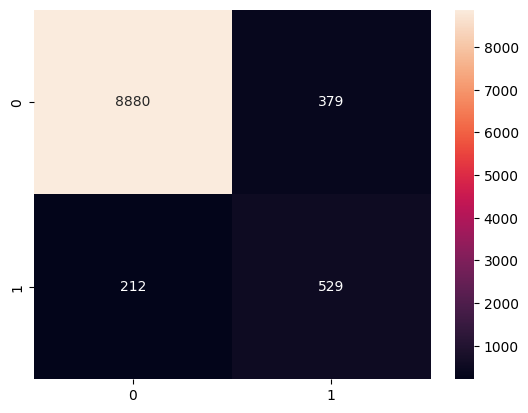

In [947]:
model_class = partial(BaggingClassifier, n_estimators=200)
all_y_pred = run_and_eval(model_class=model_class,
             X_train=X_train,
             y_train=y_train,
             X_test=X_test,
             y_test=y_test)

Accuracy: 0.9544
Precision: 0.6993006993006993
Recall: 0.6747638326585695
F1 Score: 0.6868131868131868
AUC-ROC: 0.8257715912401824
Mean Absolute Error: 0.0456
Root Mean Squared Error: 0.21354156504062624


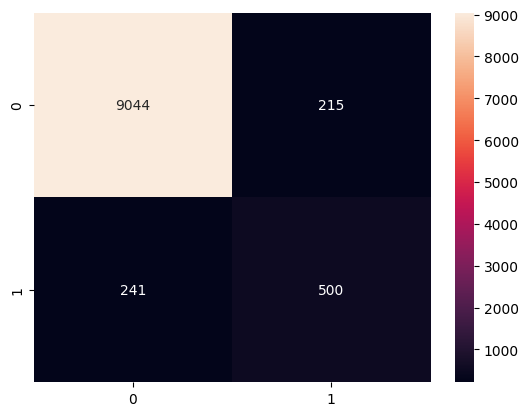

In [951]:
clf1 = AdaBoostClassifier(n_estimators=200, learning_rate=0.1)
clf2 = RandomForestClassifier(n_estimators=300, min_samples_leaf=3, max_depth=30)
clf3 = GradientBoostingClassifier(min_samples_leaf=3)
clf4 = MLPClassifier(max_iter=1000, alpha=0.01, learning_rate='adaptive')
clf5 = XGBClassifier(n_estimators=100, max_depth=30)
clf6 = BaggingClassifier(n_estimators=200)
eclf = VotingClassifier(estimators=[('ab', clf1), ('rf', clf2), ('gb', clf3), ('mlp', clf4), ('xgb', clf5), ('bg', clf6)], voting='hard')
all_y_pred = run_and_eval(model_class=eclf,
             X_train=X_train,
             y_train=y_train,
             X_test=X_test,
             y_test=y_test)

Accuracy: 0.9408
Precision: 0.5838020247469067
Recall: 0.7004048582995951
F1 Score: 0.6368098159509202
AUC-ROC: 0.8302218696941329
Mean Absolute Error: 0.0592
Root Mean Squared Error: 0.2433105012119288


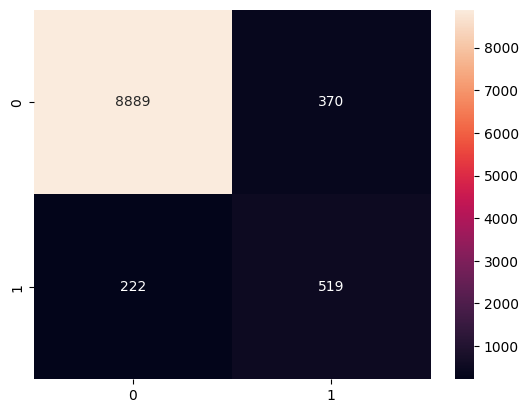

In [904]:
model_class = partial(GradientBoostingClassifier, n_estimators=300, min_samples_leaf=3, max_depth=30)
all_y_pred = run_and_eval(model_class=model_class,
             X_train=X_train,
             y_train=y_train,
             X_test=X_test,
             y_test=y_test)

Accuracy: 0.949
Precision: 0.6386554621848739
Recall: 0.717948717948718
F1 Score: 0.675984752223634
AUC-ROC: 0.8427199038496156
Mean Absolute Error: 0.051
Root Mean Squared Error: 0.22583179581272428


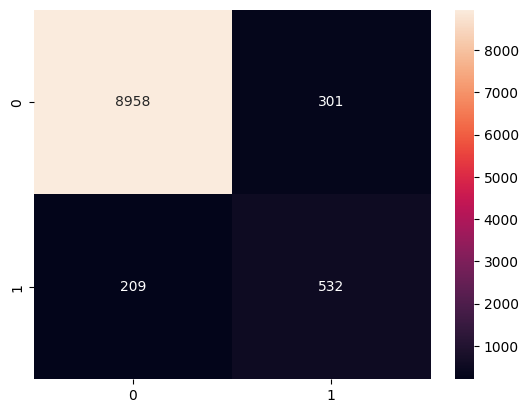

In [907]:
model_class = partial(GradientBoostingClassifier, min_samples_leaf=3)
all_y_pred = run_and_eval(model_class=model_class,
             X_train=X_train,
             y_train=y_train,
             X_test=X_test,
             y_test=y_test)

Accuracy: 0.9391
Precision: 0.5726872246696035
Recall: 0.7017543859649122
F1 Score: 0.6306852637962401
AUC-ROC: 0.8299246063100292
Mean Absolute Error: 0.0609
Root Mean Squared Error: 0.24677925358506134


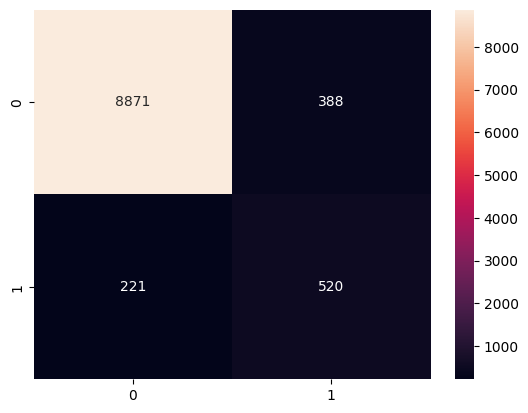

In [927]:
bst = XGBClassifier(n_estimators=100, max_depth=30)
all_y_pred = run_and_eval(model_class=bst,
             X_train=X_train,
             y_train=y_train,
             X_test=X_test,
             y_test=y_test)

Accuracy: 0.9541
Precision: 0.6963788300835655
Recall: 0.6747638326585695
F1 Score: 0.6854009595613434
AUC-ROC: 0.8256095867040554
Mean Absolute Error: 0.0459
Root Mean Squared Error: 0.2142428528562855


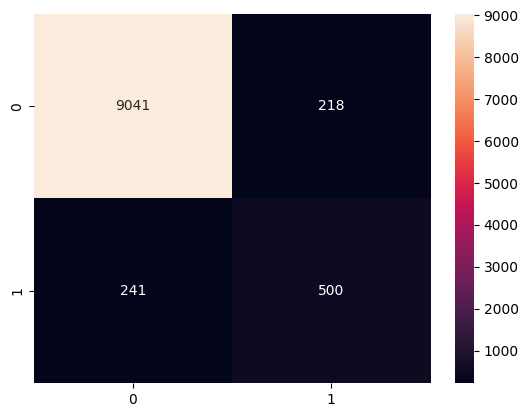

In [929]:
clf1 = AdaBoostClassifier(n_estimators=200, learning_rate=0.1)
clf2 = RandomForestClassifier(n_estimators=300, min_samples_leaf=3, max_depth=30)
clf3 = GradientBoostingClassifier(min_samples_leaf=3)
clf4 = MLPClassifier(max_iter=1000, alpha=0.01, learning_rate='adaptive')
clf5 = XGBClassifier(n_estimators=100, max_depth=30)
eclf = VotingClassifier(estimators=[('ab', clf1), ('rf', clf2), ('gb', clf3), ('xgb', clf5)], voting='hard')
all_y_pred = run_and_eval(model_class=eclf,
             X_train=X_train,
             y_train=y_train,
             X_test=X_test,
             y_test=y_test)

Accuracy: 0.9565
Precision: 0.7304216867469879
Recall: 0.6545209176788124
F1 Score: 0.6903914590747332
AUC-ROC: 0.8175941881838278
Mean Absolute Error: 0.0435
Root Mean Squared Error: 0.2085665361461421


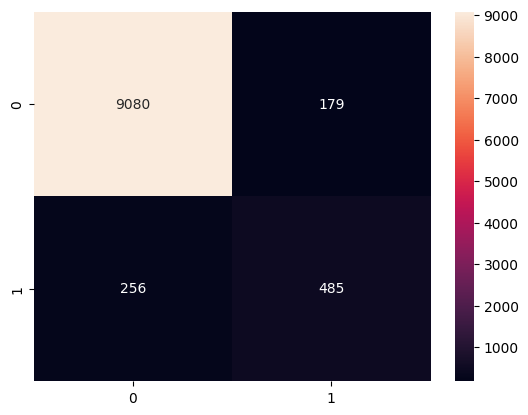

In [911]:
clf1 = AdaBoostClassifier(n_estimators=200, learning_rate=0.1)
clf2 = RandomForestClassifier(n_estimators=300, min_samples_leaf=3, max_depth=30)
clf3 = GradientBoostingClassifier(min_samples_leaf=3)
clf4 = MLPClassifier(max_iter=1000, alpha=0.01, learning_rate='adaptive')
eclf = VotingClassifier(estimators=[('ab', clf1), ('rf', clf2), ('gb', clf3), ('mlp', clf4)], voting='hard')
all_y_pred = run_and_eval(model_class=eclf,
             X_train=X_train,
             y_train=y_train,
             X_test=X_test,
             y_test=y_test)

Accuracy: 0.9546
Precision: 0.6952380952380952
Recall: 0.689608636977058
F1 Score: 0.6924119241192411
AUC-ROC: 0.8327079797910454
Mean Absolute Error: 0.0454
Root Mean Squared Error: 0.21307275752662516


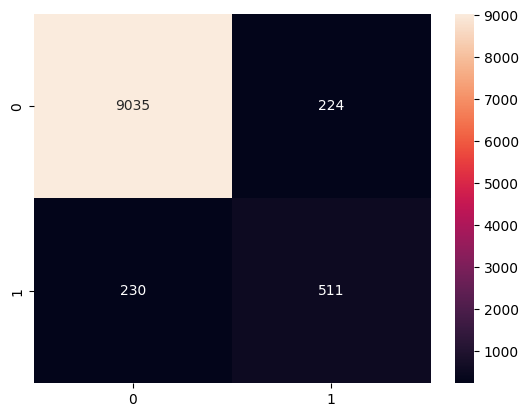

In [917]:
clf1 = AdaBoostClassifier(n_estimators=200, learning_rate=0.1)
# clf2 = RandomForestClassifier(n_estimators=300, min_samples_leaf=3, max_depth=30)
clf3 = GradientBoostingClassifier(min_samples_leaf=3)
clf4 = MLPClassifier(max_iter=1000, alpha=0.01, learning_rate='adaptive')
eclf = VotingClassifier(estimators=[('ab', clf1), ('gb', clf3), ('mlp', clf4)], voting='hard')
all_y_pred = run_and_eval(model_class=eclf,
             X_train=X_train,
             y_train=y_train,
             X_test=X_test,
             y_test=y_test)

Accuracy: 0.9497
Precision: 0.6491228070175439
Recall: 0.699055330634278
F1 Score: 0.6731643924626382
AUC-ROC: 0.8344072419452846
Mean Absolute Error: 0.0503
Root Mean Squared Error: 0.22427661492005804


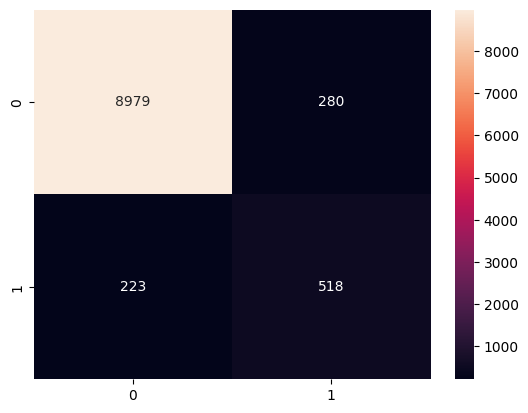

In [919]:
clf1 = AdaBoostClassifier(n_estimators=200, learning_rate=0.1)
clf2 = RandomForestClassifier(n_estimators=300, min_samples_leaf=3, max_depth=30)
clf3 = GradientBoostingClassifier(min_samples_leaf=3)
# clf4 = MLPClassifier(max_iter=1000, alpha=0.01, learning_rate='adaptive')
eclf = VotingClassifier(estimators=[('ab', clf1), ('rf', clf2), ('gb', clf3)], voting='hard')
all_y_pred = run_and_eval(model_class=eclf,
             X_train=X_train,
             y_train=y_train,
             X_test=X_test,
             y_test=y_test)

Accuracy: 0.9557
Precision: 0.718475073313783
Recall: 0.6612685560053981
F1 Score: 0.6886858749121574
AUC-ROC: 0.8202659876905704
Mean Absolute Error: 0.0443
Root Mean Squared Error: 0.21047565179849187


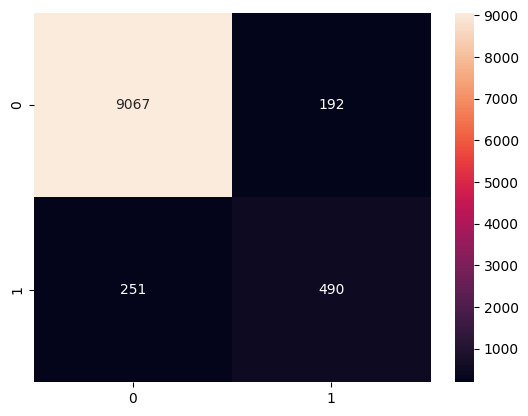

In [892]:
clf1 = AdaBoostClassifier(n_estimators=200, learning_rate=0.1)
clf2 = RandomForestClassifier(n_estimators=300, min_samples_leaf=3, max_depth=30)
clf3 = MLPClassifier(max_iter=1000, alpha=0.01, learning_rate='adaptive')
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard')
all_y_pred = run_and_eval(model_class=eclf,
             X_train=X_train,
             y_train=y_train,
             X_test=X_test,
             y_test=y_test)

Accuracy: 0.9312
Precision: 0.5518590998043053
Recall: 0.3805668016194332
F1 Score: 0.4504792332268371
AUC-ROC: 0.6779170545520214
Mean Absolute Error: 0.0688
Root Mean Squared Error: 0.26229754097208


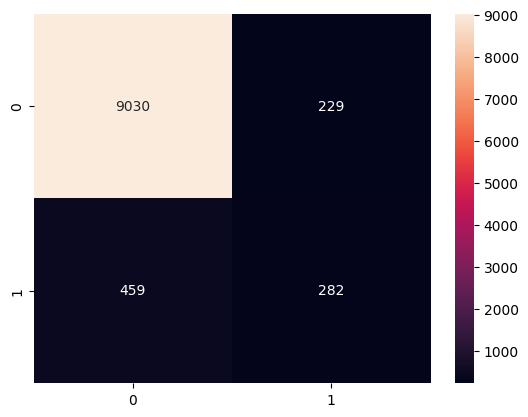

In [869]:
model_class = partial(RandomForestClassifier, n_estimators=300, min_samples_leaf=3, max_depth=30)
all_y_pred = run_and_eval(model_class=model_class,
             X_train=X_train,
             y_train=y_train,
             X_test=X_test,
             y_test=y_test)

In [819]:
features_to_process = list(set(X_train.columns) - set(['Gender', 'Unit1', 'SepsisLabel', 'patient id', 'Gender', 'Age', 'HospAdmTime']))
features_to_process = [x for x in features_to_process if "last_5_rows" not in x]
features_to_process.extend(['slope_HospAdmTime_last_5_rows', 'slope_patient id_last_5_rows', 'slope_Age_last_5_rows', 'mean_HospAdmTime_last_5_rows', 'mean_patient id_last_5_rows', 'mean_Age_last_5_rows'])
features_to_process
x_train_temp = X_train.drop(features_to_process, axis=1)
x_train_temp.columns

Index(['patient id', 'Age', 'Gender', 'Unit1', 'HospAdmTime',
       'slope_BUN_last_5_rows', 'slope_Glucose_last_5_rows',
       'slope_Temp_last_5_rows', 'slope_Hct_last_5_rows',
       'slope_MAP_last_5_rows', 'slope_ICULOS_last_5_rows',
       'slope_Hgb_last_5_rows', 'slope_pH_last_5_rows',
       'slope_Phosphate_last_5_rows', 'slope_FiO2_last_5_rows',
       'slope_PTT_last_5_rows', 'slope_PaCO2_last_5_rows',
       'slope_Creatinine_last_5_rows', 'slope_Lactate_last_5_rows',
       'slope_Platelets_last_5_rows', 'slope_WBC_last_5_rows',
       'slope_Calcium_last_5_rows', 'slope_HR_last_5_rows',
       'mean_BUN_last_5_rows', 'mean_Glucose_last_5_rows',
       'mean_Temp_last_5_rows', 'mean_Hct_last_5_rows', 'mean_MAP_last_5_rows',
       'mean_ICULOS_last_5_rows', 'mean_Hgb_last_5_rows',
       'mean_pH_last_5_rows', 'mean_Phosphate_last_5_rows',
       'mean_FiO2_last_5_rows', 'mean_PTT_last_5_rows',
       'mean_PaCO2_last_5_rows', 'mean_Creatinine_last_5_rows',
       'mean

In [816]:
x_train_temp = X_train.drop(features_to_process, axis=1)
zero_percentages = (x_train_temp == 0).sum() / len(x_train_temp) * 100
zero_percentages.sort_values(ascending=False)

slope_HospAdmTime_last_5_rows    100.000000
slope_patient id_last_5_rows     100.000000
slope_Age_last_5_rows            100.000000
slope_Phosphate_last_5_rows       99.752650
slope_Creatinine_last_5_rows      99.664311
slope_BUN_last_5_rows             99.593640
slope_PTT_last_5_rows             99.469965
slope_WBC_last_5_rows             99.399293
slope_Platelets_last_5_rows       99.310954
slope_Calcium_last_5_rows         98.763251
slope_Hgb_last_5_rows             98.498233
slope_Lactate_last_5_rows         98.215548
slope_Hct_last_5_rows             97.756184
slope_FiO2_last_5_rows            96.395760
slope_PaCO2_last_5_rows           95.459364
slope_pH_last_5_rows              94.946996
slope_Glucose_last_5_rows         86.254417
Unit1                             68.639576
slope_Temp_last_5_rows            67.862191
Gender                            44.699647
slope_HR_last_5_rows               7.473498
slope_MAP_last_5_rows              7.367491
mean_HospAdmTime_last_5_rows    

Accuracy: 0.9454
Precision: 0.6229508196721312
Recall: 0.6666666666666666
F1 Score: 0.6440677966101694
AUC-ROC: 0.8171868812326745
Mean Absolute Error: 0.0546
Root Mean Squared Error: 0.23366642891095846


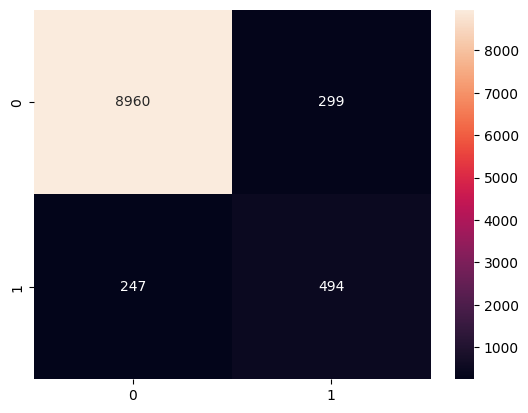

In [820]:
model_class = partial(RandomForestClassifier, n_estimators=300, min_samples_leaf=3, max_depth=30)
all_y_pred = run_and_eval(model_class=model_class,
             X_train=X_train.drop(features_to_process, axis=1),
             y_train=y_train,
             X_test=X_test.drop(features_to_process, axis=1),
             y_test=y_test)

Accuracy: 0.883
Precision: 0.350104821802935
Recall: 0.6761133603238867
F1 Score: 0.4613259668508287
AUC-ROC: 0.7878352739625697
Mean Absolute Error: 0.117
Root Mean Squared Error: 0.3420526275297414


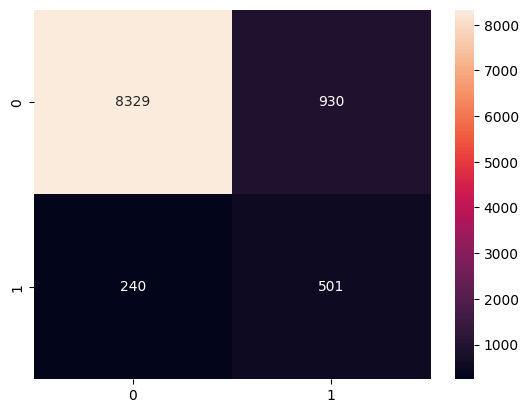

In [789]:
# MLP
model_class = partial(MLPClassifier, max_iter=1000, alpha=0.01, learning_rate='adaptive')
all_y_pred = run_and_eval(model_class=model_class,
             X_train=X_train,
             y_train=y_train,
             X_test=X_test,
             y_test=y_test)

Accuracy: 0.9185
Precision: 0.4155251141552511
Recall: 0.24561403508771928
F1 Score: 0.30873621713316374
AUC-ROC: 0.6089826304610212
Mean Absolute Error: 0.0815
Root Mean Squared Error: 0.28548204847240394


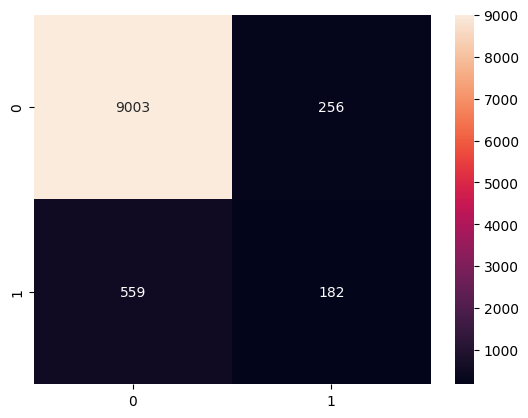

In [783]:
# KNN
model_class = partial(KNeighborsClassifier)
all_y_pred = run_and_eval(model_class=model_class,
             X_train=X_train,
             y_train=y_train,
             X_test=X_test,
             y_test=y_test)

Accuracy: 0.9155
Precision: 0.42876712328767125
Recall: 0.4224021592442645
F1 Score: 0.4255608429639701
AUC-ROC: 0.6886824491004776
Mean Absolute Error: 0.0845
Root Mean Squared Error: 0.2906888370749727


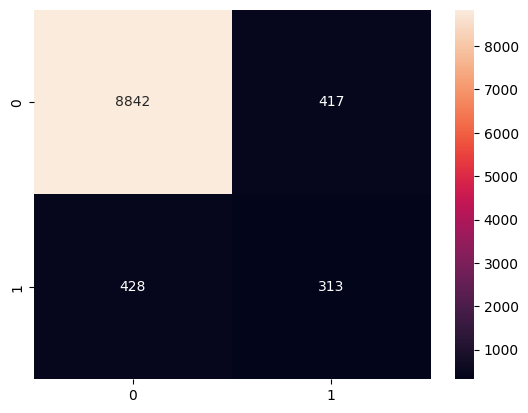

In [779]:
# SVC
model_class = partial(SVC, gamma='auto')
all_y_pred = run_and_eval(model_class=model_class,
             X_train=X_train,
             y_train=y_train,
             X_test=X_test,
             y_test=y_test)

Accuracy: 0.9519
Precision: 0.6715039577836411
Recall: 0.6869095816464238
F1 Score: 0.6791194129419613
AUC-ROC: 0.83000841432467
Mean Absolute Error: 0.0481
Root Mean Squared Error: 0.2193171219946131


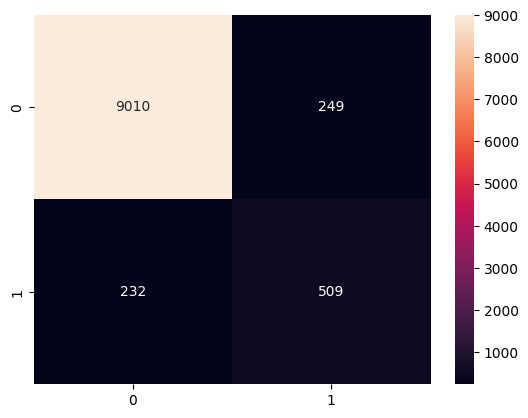

In [754]:
# ada boost
model_class = partial(AdaBoostClassifier, n_estimators=200, learning_rate=0.1)
all_y_pred = run_and_eval(model_class=model_class,
             X_train=X_train,
             y_train=y_train,
             X_test=X_test,
             y_test=y_test)

Accuracy: 0.8831
Precision: 0.34844192634560905
Recall: 0.6639676113360324
F1 Score: 0.4570366929865304
AUC-ROC: 0.782302414589066
Mean Absolute Error: 0.1169
Root Mean Squared Error: 0.3419064199455752


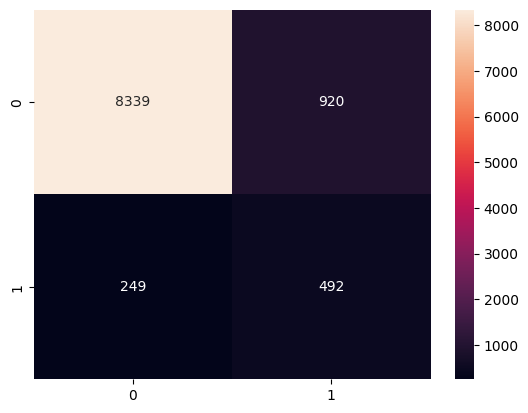

In [742]:
# decision tree
model_class = partial(DecisionTreeClassifier, min_samples_leaf=3, max_depth=30)
all_y_pred = run_and_eval(model_class=model_class,
             X_train=X_train,
             y_train=y_train,
             X_test=X_test,
             y_test=y_test)

Accuracy: 0.949
Precision: 0.6471337579617834
Recall: 0.6855600539811066
F1 Score: 0.6657929226736565
AUC-ROC: 0.8278216081548259
Mean Absolute Error: 0.051
Root Mean Squared Error: 0.22583179581272428


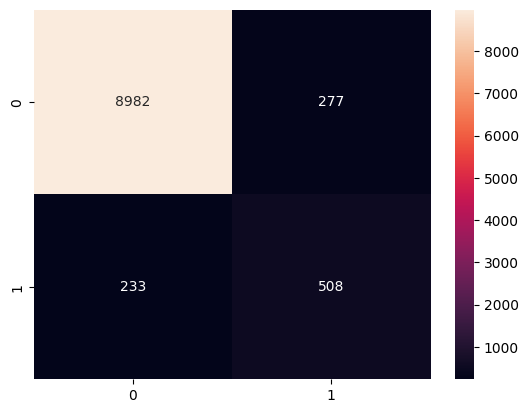

In [738]:
# adding sirs
model_class = partial(RandomForestClassifier, n_estimators=300, min_samples_leaf=3, max_depth=30)
all_y_pred = run_and_eval(model_class=model_class,
             X_train=X_train,
             y_train=y_train,
             X_test=X_test,
             y_test=y_test)

Accuracy: 0.9531
Precision: 0.6942857142857143
Recall: 0.6558704453441295
F1 Score: 0.6745315752949341
AUC-ROC: 0.8163788990950046
Mean Absolute Error: 0.0469
Root Mean Squared Error: 0.21656407827707713


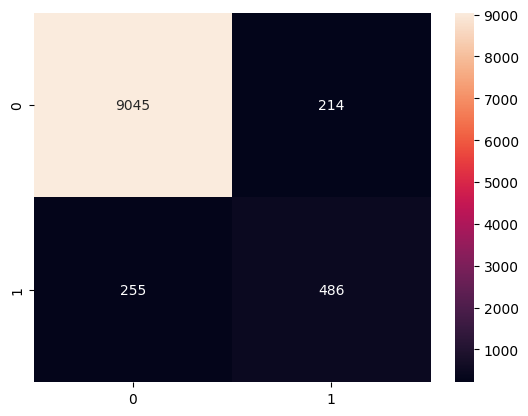

In [673]:
over_sampler = RandomOverSampler(sampling_strategy=0.25)
under_sampler = RandomUnderSampler(sampling_strategy=0.5)
pipeline = Pipeline(steps=[('over', over_sampler), ('under', under_sampler)])
X_sampled, y_sampled = pipeline.fit_resample(X_train, y_train)

# over sampling with repetitions, under sampling with ratio
model_class = partial(RandomForestClassifier, n_estimators=300, min_samples_leaf=3, max_depth=30)
all_y_pred = run_and_eval(model_class=model_class,
             X_train=X_sampled,
             y_train=y_sampled,
             X_test=X_test,
             y_test=y_test)

Accuracy: 0.9336
Precision: 0.5385385385385385
Recall: 0.7260458839406208
F1 Score: 0.618390804597701
AUC-ROC: 0.838128244918793
Mean Absolute Error: 0.0664
Root Mean Squared Error: 0.25768197453450253


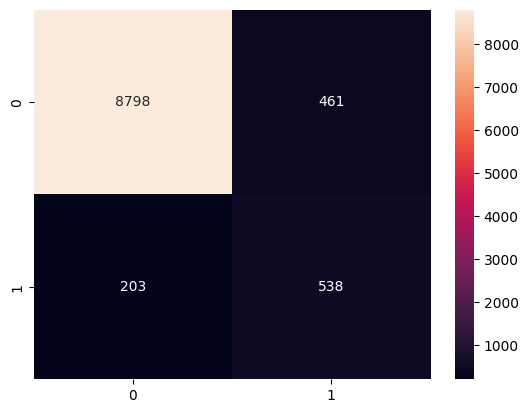

In [667]:
# smote
model_class = partial(RandomForestClassifier, n_estimators=300, min_samples_leaf=3, max_depth=30)
all_y_pred = run_and_eval(model_class=model_class,
             X_train=X_sampled,
             y_train=y_sampled,
             X_test=X_test,
             y_test=y_test)

Accuracy: 0.9543
Precision: 0.6988795518207283
Recall: 0.6734143049932524
F1 Score: 0.6859106529209622
AUC-ROC: 0.8250968274075238
Mean Absolute Error: 0.0457
Root Mean Squared Error: 0.2137755832643195


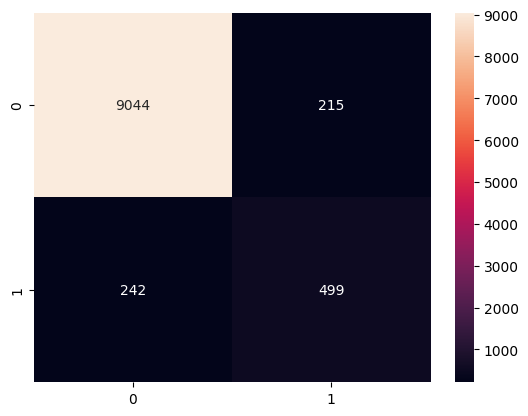

In [651]:
# undersampling 3, without scaling, new feature selection
model_class = partial(RandomForestClassifier, n_estimators=300, min_samples_leaf=3, max_depth=30)
all_y_pred = run_and_eval(model_class=model_class,
             X_train=X_train,
             y_train=y_train,
             X_test=X_test,
             y_test=y_test)

Accuracy: 0.9526
Precision: 0.8312655086848635
Recall: 0.45209176788124156
F1 Score: 0.5856643356643357
AUC-ROC: 0.7223737811217419
Mean Absolute Error: 0.0474
Root Mean Squared Error: 0.2177154105707724


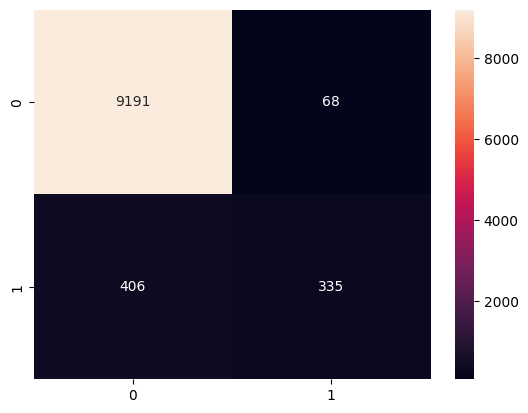

In [641]:
model_class = partial(RandomForestClassifier, n_estimators=300, min_samples_leaf=3, max_depth=30)
all_y_pred = run_and_eval(model_class=model_class,
             X_train=X_train,
             y_train=y_train,
             X_test=X_test,
             y_test=y_test)

Accuracy: 0.9511
Precision: 0.828125
Recall: 0.4291497975708502
F1 Score: 0.5653333333333332
AUC-ROC: 0.7110107989906309
Mean Absolute Error: 0.0489
Root Mean Squared Error: 0.2211334438749598


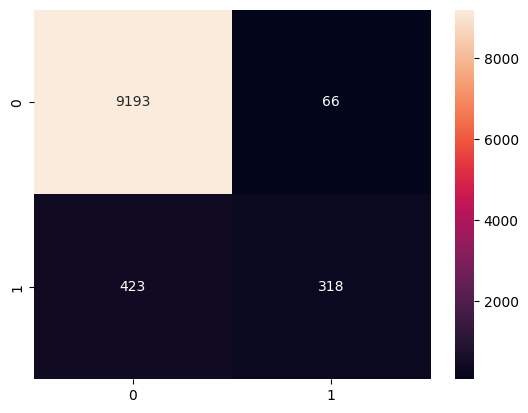

In [638]:
model_class = partial(RandomForestClassifier, n_estimators=300, min_samples_leaf=3)
all_y_pred = run_and_eval(model_class=model_class,
             X_train=X_train,
             y_train=y_train,
             X_test=X_test,
             y_test=y_test)

Accuracy: 0.9499
Precision: 0.8680981595092024
Recall: 0.38191632928475033
F1 Score: 0.5304592314901593
AUC-ROC: 0.6886360996245546
Mean Absolute Error: 0.0501
Root Mean Squared Error: 0.2238302928559939


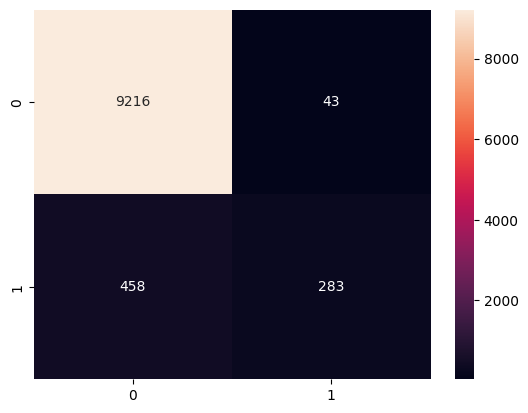

In [635]:
model_class = partial(RandomForestClassifier, n_estimators=300, min_samples_leaf=3)
all_y_pred = run_and_eval(model_class=model_class,
             X_train=X_train,
             y_train=y_train,
             X_test=X_test,
             y_test=y_test)

Accuracy: 0.9498
Precision: 0.8676923076923077
Recall: 0.3805668016194332
F1 Score: 0.5290806754221389
AUC-ROC: 0.6879613357918961
Mean Absolute Error: 0.0502
Root Mean Squared Error: 0.2240535650240808


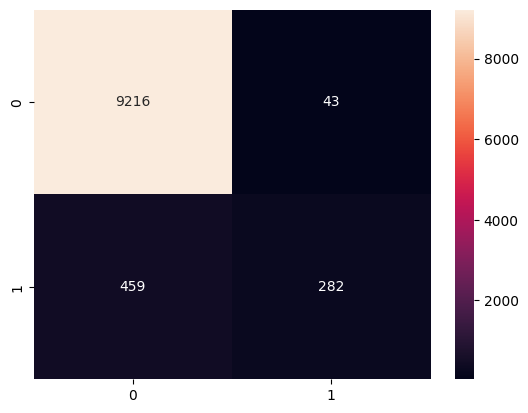

In [632]:
model_class = partial(RandomForestClassifier, n_estimators=300, min_samples_leaf=3)
all_y_pred = run_and_eval(model_class=model_class,
             X_train=X_train,
             y_train=y_train,
             X_test=X_test,
             y_test=y_test)

Accuracy: 0.9487
Precision: 0.875
Recall: 0.358974358974359
F1 Score: 0.509090909090909
AUC-ROC: 0.6774351220295707
Mean Absolute Error: 0.0513
Root Mean Squared Error: 0.2264950330581225


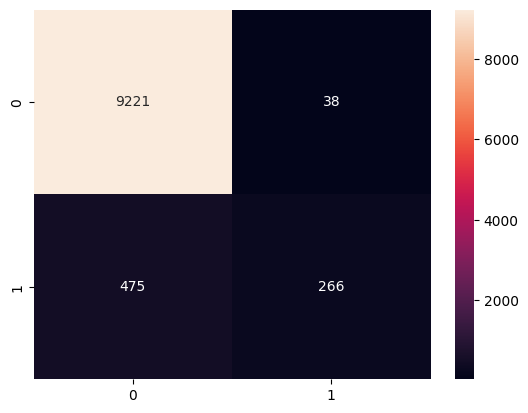

In [626]:
model_class = partial(RandomForestClassifier, n_estimators=300, min_samples_leaf=3)
all_y_pred = run_and_eval(model_class=model_class,
             X_train=X_train,
             y_train=y_train,
             X_test=X_test,
             y_test=y_test)

Accuracy: 0.9311
Precision: 0.5656565656565656
Recall: 0.30229419703103916
F1 Score: 0.39401934916446785
AUC-ROC: 0.6418588384442376
Mean Absolute Error: 0.0689
Root Mean Squared Error: 0.26248809496813374


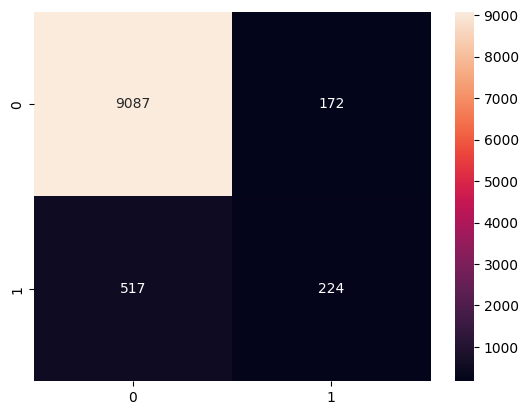

In [536]:
# new feature selection
model_class = partial(RandomForestClassifier, n_estimators=300, min_samples_leaf=3)
all_y_pred = run_and_eval(model_class=model_class,
             X_train=X_train,
             y_train=y_train,
             X_test=X_test,
             y_test=y_test)

Accuracy: 0.9247
Precision: 0.48598130841121495
Recall: 0.2807017543859649
F1 Score: 0.3558597091531223
AUC-ROC: 0.6284705445436682
Mean Absolute Error: 0.0753
Root Mean Squared Error: 0.2744084546802449


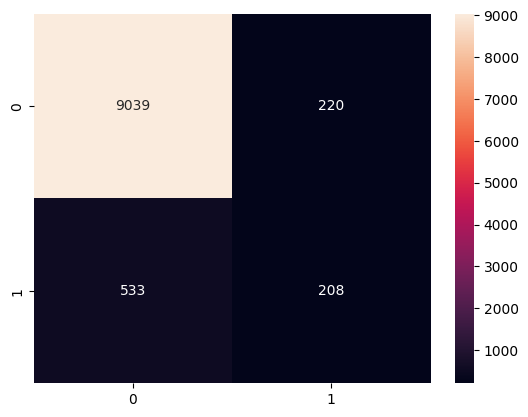

In [497]:
model_class = partial(RandomForestClassifier, n_estimators=300, min_samples_leaf=3)
all_y_pred = run_and_eval(model_class=model_class,
             X_train=X_train,
             y_train=y_train,
             X_test=X_test,
             y_test=y_test)

Accuracy: 0.8997
Precision: 0.23155737704918034
Recall: 0.1524966261808367
F1 Score: 0.18388934092758338
AUC-ROC: 0.5559977460745419
Mean Absolute Error: 0.1003
Root Mean Squared Error: 0.3167017524422623


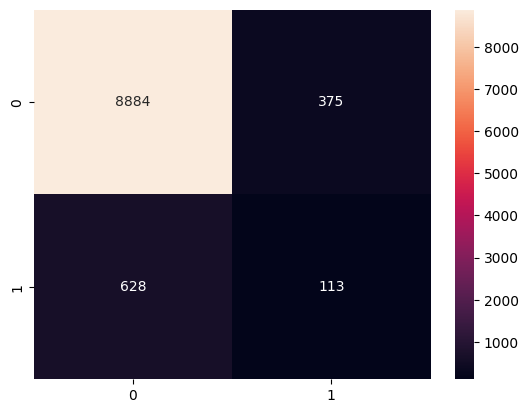

In [500]:
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()
X_train_copy = X_train_copy.drop('ICULOS', axis=1)
X_test_copy = X_test_copy.drop('ICULOS', axis=1)
model_class = partial(RandomForestClassifier, n_estimators=300, min_samples_leaf=3)
all_y_pred = run_and_eval(model_class=model_class,
             X_train=X_train_copy,
             y_train=y_train,
             X_test=X_test_copy,
             y_test=y_test)

Accuracy: 0.9189
Precision: 0.41586538461538464
Recall: 0.23346828609986506
F1 Score: 0.29904926534140014
AUC-ROC: 0.6036117756236447
Mean Absolute Error: 0.0811
Root Mean Squared Error: 0.28478061731796284


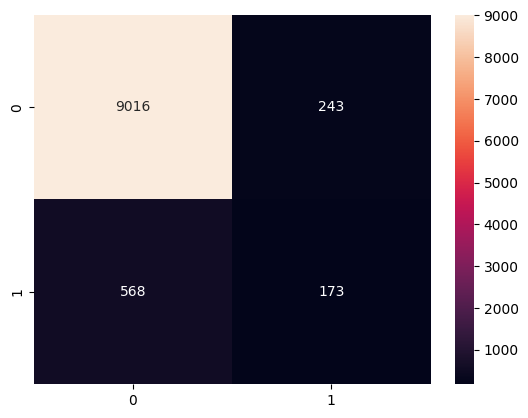

In [398]:
# with under sampling, without patient id, with pivot series of num_hours = 5
model_class = partial(RandomForestClassifier, n_estimators=300, min_samples_leaf=3)
all_y_pred = run_and_eval(model_class=model_class,
             X_train=X_train,
             y_train=y_train,
             X_test=X_test,
             y_test=y_test)

Accuracy: 0.9171
Precision: 0.4105691056910569
Recall: 0.2726045883940621
F1 Score: 0.32765612327656124
AUC-ROC: 0.6206418557047533
Mean Absolute Error: 0.0829
Root Mean Squared Error: 0.2879236009777594


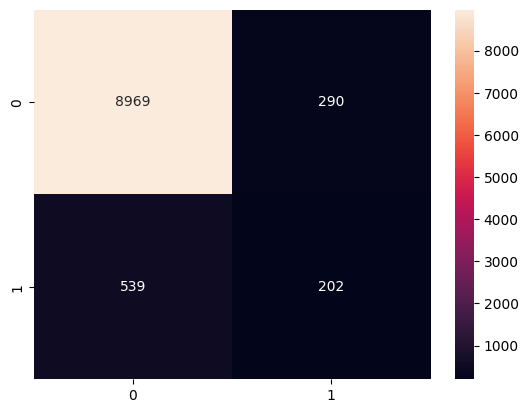

In [378]:
# with under sampling, without patient id, with pivot series of num_hours = 3 
model_class = partial(RandomForestClassifier, n_estimators=300, min_samples_leaf=3)
all_y_pred = run_and_eval(model_class=model_class,
             X_train=X_train,
             y_train=y_train,
             X_test=X_test,
             y_test=y_test)

Accuracy: 0.9284
Precision: 0.5444839857651246
Recall: 0.20647773279352227
F1 Score: 0.29941291585127205
AUC-ROC: 0.596326672855342
Mean Absolute Error: 0.0716
Root Mean Squared Error: 0.26758176320519306


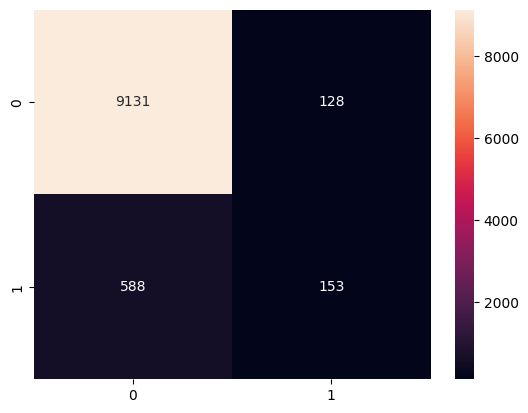

In [395]:
# different evaluation of y pred
X_test_copy = X_test.copy()
X_test_copy['preds'] = all_y_pred
y_pred_per_patient = pd.DataFrame(X_test_copy.groupby('patient id')['preds'].apply(lambda x: int((x.tail(5) == 1).any())))
evaluate_model(y_test, y_pred_per_patient)

Accuracy: 0.9303
Precision: 0.5544554455445545
Recall: 0.30229419703103916
F1 Score: 0.3912663755458516
AUC-ROC: 0.6414268263478989
Mean Absolute Error: 0.0697
Root Mean Squared Error: 0.2640075756488817


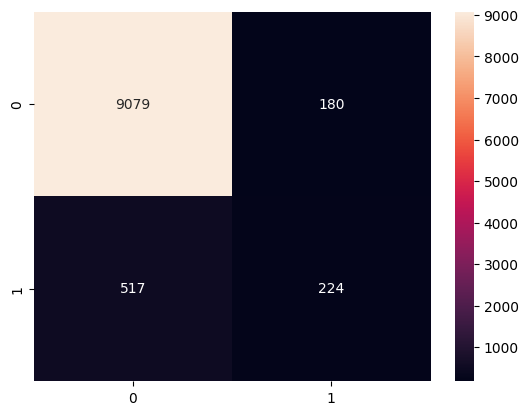

In [362]:
# with under sampling, without patient id
model_class = partial(RandomForestClassifier, n_estimators=300, min_samples_leaf=3)
all_y_pred = run_and_eval(model_class=model_class,
             X_train=X_train,
             y_train=y_train,
             X_test=X_test,
             y_test=y_test)

In [373]:
def add_time_series_cols(x_df, features_to_process, num_hours, y_df=None):
    rows_dict = x_df.groupby('patient id').size().to_dict()
    for feature in features_to_process:
        for hour in range(1, num_hours+1):
            x_df[f'{feature}_before_{hour}_hour'] = x_df.groupby('patient id')[feature].shift(hour)

    for patient_id, num_rows in rows_dict.items():
        if num_rows <= num_hours:
            last_row = x_df[x_df['patient id'] == patient_id].iloc[-1]
            for feature in features_to_process:
                for i in range(num_rows, num_hours+1):
                    if i == 1:
                        val = last_row[feature]
                    else:
                        val = last_row[f'{feature}_before_{i-1}_hour']
                    last_row[f'{feature}_before_{i}_hour'] = val
                    
            for i in range(num_hours - num_rows + 1):
                x_df = pd.concat([x_df, pd.DataFrame(last_row).T], axis=0)
           
    x_df = x_df.groupby('patient id').apply(lambda x: x.iloc[num_hours:])
    x_df = x_df.reset_index(drop=True)
#     if y_df is not None:
#         y_df = y_df[y_df.index.isin(x_df.index)]
    return x_df, y_df 

In [440]:
def add_last_n_mean_cols(df, cols_to_process, n):
    for col in cols_to_process:
        new_col = f'mean_{col}_last_{n}_rows'
        df[new_col] = df.groupby('patient id')[col].rolling(window=n, min_periods=1).mean().reset_index(drop=True)
    return df

In [468]:
def get_slope(x):
    if len(x) <= 1:
        return 0
    slope = linregress(range(len(x)), x).slope
    return slope

def add_last_n_slope_cols(df, cols_to_process, n):
    for col in cols_to_process:
        new_col = f'slope_{col}_last_{n}_rows'
        df[new_col] = (df.groupby('patient id')[col]
                       .rolling(window=n, min_periods=1)
                       .apply(lambda x: get_slope(x))
                       .reset_index(drop=True))
    return df

In [469]:
mini_df = pd.DataFrame({'patient id': ['A', 'A', 'A', 'A', 'B', 'B', 'C', 'D', 'D', 'D'],
                      'x': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]})
mini_df

,patient id,x
0,A,1
1,A,2
2,A,3
3,A,4
4,B,5
5,B,6
6,C,7
7,D,8
8,D,9
9,D,10


In [470]:
add_last_n_mean_cols(mini_df, ['x'], n=3)

,patient id,x,mean_x_last_3_rows
0,A,1,1.0
1,A,2,1.5
2,A,3,2.0
3,A,4,3.0
4,B,5,5.0
5,B,6,5.5
6,C,7,7.0
7,D,8,8.0
8,D,9,8.5
9,D,10,9.0


In [472]:
add_last_n_slope_cols(mini_df, ['x'], n=3)

,patient id,x,mean_x_last_3_rows,slope_x_last_3_rows
0,A,1,1.0,0.0
1,A,2,1.5,1.0
2,A,3,2.0,1.0
3,A,4,3.0,1.0
4,B,5,5.0,0.0
5,B,6,5.5,1.0
6,C,7,7.0,0.0
7,D,8,8.0,0.0
8,D,9,8.5,1.0
9,D,10,9.0,1.0


In [368]:
res, _ = add_time_series_cols(mini_df, ['x'], 3)
res

,patient id,x,x_before_1_hour,x_before_2_hour,x_before_3_hour
0,A,4,3,2,1
1,B,6,5,5,5
2,C,7,7,7,7
3,D,10,9,8,8


In [336]:
features_to_process = set(X_train.columns) - set(['Age', 'Gender', 'Unit1', 'Unit2','HospAdmTime', 'ICULOS', 'SepsisLabel', 'patient id'])
X_train, y_train = add_time_series_cols(X_train, features_to_process, 3, y_train)
X_test,_ = add_time_series_cols(X_test, features_to_process, 3)

C:\Users\maaya\AppData\Local\Temp\ipykernel_2596\207783653.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  x_df[f'{feature}_before_{hour}_hour'] = x_df.groupby('patient id')[feature].shift(hour)
C:\Users\maaya\AppData\Local\Temp\ipykernel_2596\207783653.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  x_df[f'{feature}_before_{hour}_hour'] = x_df.groupby('patient id')[feature].shift(hour)
C:\Users\maaya\AppData\Local\Temp\ipykernel_2596\207783653.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually th

In [337]:
print(X_train.shape)
print(y_train.shape)

(706884, 106)
(706884,)


Accuracy: 0.9259
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
AUC-ROC: 0.5
Mean Absolute Error: 0.0741
Root Mean Squared Error: 0.272213151776324


c:\users\maaya\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


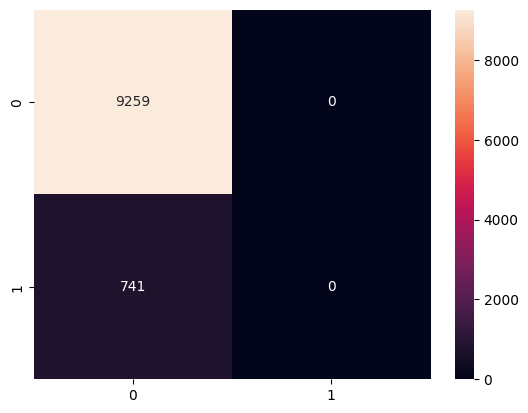

In [340]:
# without under sampling and class weight=balanced and pivoted cols 
model_class = partial(RandomForestClassifier, n_estimators=300, min_samples_leaf=3, class_weight="balanced")
all_y_pred = run_and_eval(model_class=model_class,
             X_train=X_train,
             y_train=y_train,
             X_test=X_test,
             y_test=y_test)

Accuracy: 0.9343
Precision: 0.64
Recall: 0.2591093117408907
F1 Score: 0.3688760806916426
AUC-ROC: 0.623722492569873
Mean Absolute Error: 0.0657
Root Mean Squared Error: 0.2563201123595259


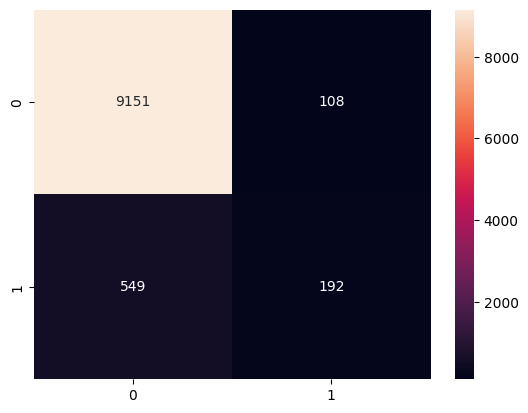

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [118]:
# without under sampling and class weight=balanced, regular schema
model_class = partial(RandomForestClassifier, n_estimators=300, min_samples_leaf=3, class_weight="balanced")
run_and_eval(model_class=model_class,
             X_train=X_train,
             y_train=y_train,
             X_test=X_test,
             y_test=y_test)

Accuracy: 0.9359
Precision: 0.6724137931034483
Recall: 0.2631578947368421
F1 Score: 0.3782735208535402
AUC-ROC: 0.626448803724399
Mean Absolute Error: 0.0641
Root Mean Squared Error: 0.25317977802344327


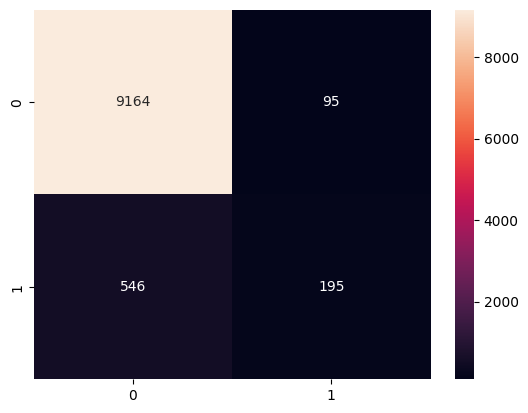

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [115]:
# with under-sampling = 3*minority, regular schema
model_class = partial(RandomForestClassifier, n_estimators=300, min_samples_leaf=3)
run_and_eval(model_class=model_class,
             X_train=X_train,
             y_train=y_train,
             X_test=X_test,
             y_test=y_test)

Accuracy: 0.9238
Precision: 0.4784394250513347
Recall: 0.3144399460188934
F1 Score: 0.3794788273615635
AUC-ROC: 0.643503588950693
Mean Absolute Error: 0.0762
Root Mean Squared Error: 0.2760434748368452


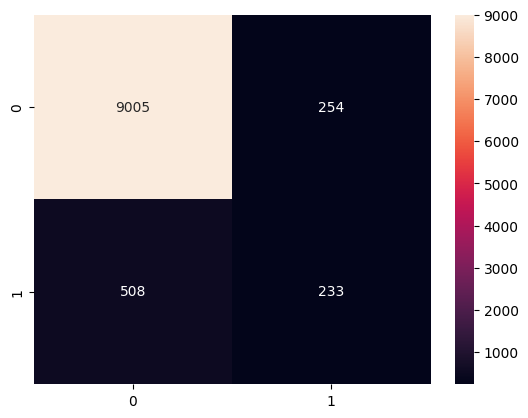

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [108]:
# with under-sampling = 2*minority, regular schema
model_class = partial(RandomForestClassifier, n_estimators=300, min_samples_leaf=3)
run_and_eval(model_class=model_class,
             X_train=X_train,
             y_train=y_train,
             X_test=X_test,
             y_test=y_test)

In [ ]:
# {'DBP', 'SBP','pH','HCO3', 'Hgb', 'Bilirubin_direct', 'EtCO2', 'Fibrinogen', 'TroponinI', 'Unit2'}

In [546]:
label_counts = df.groupby('patient id')['SepsisLabel'].sum()
num_patients_with_zero_ones = (label_counts == 0).sum()
num_patients_with_zero_ones

label_counts = df.groupby('patient id')['SepsisLabel'].sum()
patient_ids_to_sample = label_counts[label_counts == 0].index.tolist()
patients_to_drop = random.sample(patient_ids_to_sample, 17000)
balanced_df = df[~df['patient id'].isin(patients_to_drop)]

label_counts = balanced_df.groupby('patient id')['SepsisLabel'].sum()
num_patients_with_zero_ones = (label_counts == 0).sum()
num_patients_with_zero_ones

majority_class = balanced_df[balanced_df['SepsisLabel'] == 0]
minority_class = balanced_df[balanced_df['SepsisLabel'] == 1]
print("\nBalanced Ratio:")
print(len(majority_class))
print(len(minority_class))

label_counts = balanced_df.groupby('patient id')['SepsisLabel'].sum()
num_patients_with_zero_ones = (label_counts == 0).sum()
num_patients_with_zero_ones

18585